In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Tue May 25 12:48:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 패키지 불러오기

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import sin, cos, sqrt, atan2, radians, degrees
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from tqdm import tqdm

## 데이터 불러오기

In [7]:
train=pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/sample_submission.csv')

In [8]:
print('train shape :', train.shape)
print('test shape :',test.shape)

train shape : (1458644, 11)
test shape : (625134, 9)


- ID - 각 여행에 대한 고유 식별자
- vendor_id - 여행 기록과 관련된 공급자를 나타내는 코드
- pickup_datetime - 미터가 종사한 날짜 및 시간
- dropoff_datetime - 미터가 분리된 날짜 및 시간
- passenger_count - 차량의 승객 수 (운전자가 값을 입력)
- pickup_longitude - 미터가 종사하는 경도
- pickup_latitude - 미터가 종사하는 위도
- dropoff_longitude - 미터가 분리 된 경도
- dropoff_latitude - 미터가 분리 된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 공급 업체에 보내기 전에 여행 기록이 차량 메모리에 보관되었는지 여부를 나타냅니다.-Y = 저장 및 전달; N = 저장 및 전진 여행 아님
- trip_duration - 초 여행의 기간

In [9]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
print('########### train ##################')
print(train.info())

print('########### test ##################')
print(test.info())

########### train ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
########### test ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data

In [11]:
print('############# train 결측치 ##############')
print(train.isnull().sum())

print('############# test 결측치 ##############')
print(test.isnull().sum())

############# train 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
############# test 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


- 결측치는 모든 데이터에 없다.

In [12]:
print('####################### train ##################')
display(train.describe())

print('###################### test ###################')
display(test.describe())

####################### train ##################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


###################### test ###################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [13]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# trip_duration을 target으로 바꿔준다.
train=train.rename(columns = {'trip_duration':'target'})

In [14]:
def sub_function(x):
    a=set(train[x].unique())
    b =set(test[x].unique())
    a =a.difference(test[x])
    b =b.difference(train[x])
    print(f'train_set 에만 있는 값 {a}')
    print(f'test_set 에만 있는 값 {b}')    

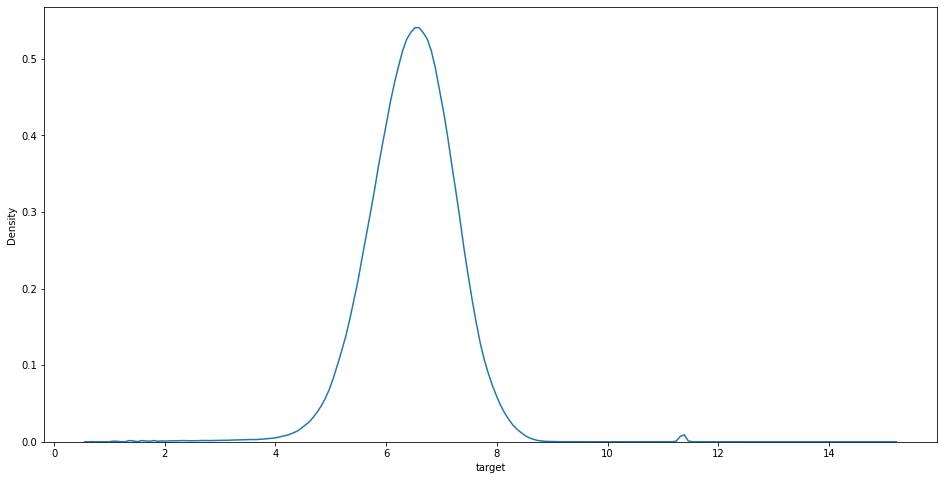

In [15]:
# target에 정규화를 시켜주고 분석을 진행해 주자.
plt.figure(figsize = (16,8))
sns.kdeplot(train['target'].apply(lambda x:np.log1p(x)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


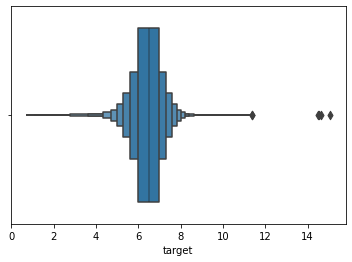

In [16]:
# target의 이상치를 제거한다.
sns.boxenplot(train['target'].apply(lambda x:np.log1p(x)))

In [17]:
# 이상치를 전부 제거해준다.
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

outlier_idx = get_outlier(df = train, column = 'target', weight = 1.5)
train.drop(outlier_idx, axis = 0, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


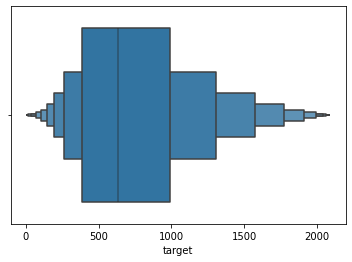

In [18]:
sns.boxenplot(train['target'])

In [19]:
# 회귀분석은 정규화를 해준 이후에 데이터를 분석해야 하므로 target변수에 log를 씌운 이후 나중에 풀어주도록 하자.
train['log_target'] = train['target'].apply(lambda x: np.log1p(x))

# id

In [20]:
train['id']=train['id'].apply(lambda x:x[2:])
train['id']=train['id'].astype('int')

test['id'] = test['id'].apply(lambda x: x[2:])
test['id'] = test['id'].astype('int')

In [21]:
train['id'].describe()

count    1.384424e+06
mean     1.999128e+06
std      1.154633e+06
min      1.000000e+00
25%      9.995152e+05
50%      1.998060e+06
75%      2.999236e+06
max      4.000000e+06
Name: id, dtype: float64

In [22]:
print(train['id'].min(), train['id'].max())
print(test['id'].min(), test['id'].max())

1 4000000
2 3999997


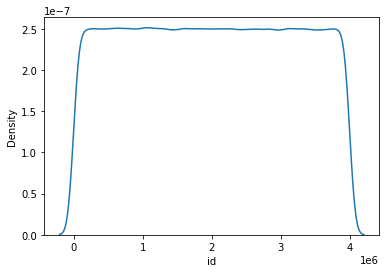

In [23]:
# 특정한 분포를 찾을 수 없으므로 이 데이터는 제거 해 주도록 하자.
sns.kdeplot(data = train, x = 'id')

## vendor_id

In [24]:
train.vendor_id.value_counts()

2    738615
1    645809
Name: vendor_id, dtype: int64

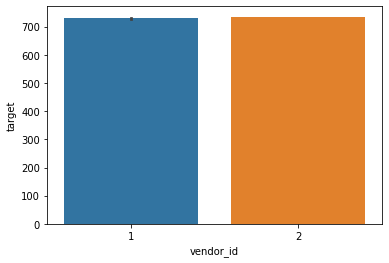

In [25]:
sns.barplot(data = train, x = 'vendor_id', y = 'target')

In [26]:
sub_function('vendor_id')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


- 이 데이터의 경우 설명도 나와 있지 않기 때문에 나중에 다른 변수와 비교할 때 사용해야 겠다.

## passenger_count

In [27]:
print('train의 passenger_count')
print(train['passenger_count'].value_counts())
print('test의 passenger_count')
print(test['passenger_count'].value_counts())

train의 passenger_count
1    983883
2    197635
5     73864
3     56558
6     45805
4     26618
0        56
7         3
9         1
8         1
Name: passenger_count, dtype: int64
test의 passenger_count
1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64


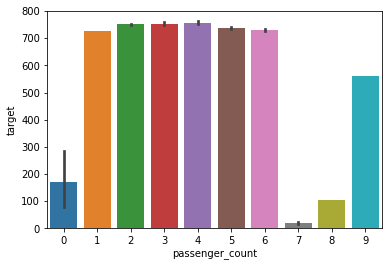

In [28]:
sns.barplot(data = train, x = 'passenger_count', y = 'target')

- 0명을 태웠다는 말은 무슨말일까?
- 일단 test셋에 7과 8이 없음으로 7과 8의 데이터를 지워주도록 하자!!

## pickup_datetime

In [29]:
def datetime(df, column):
    df['month'] = df[column].dt.month
    df['day'] = df[column].dt.day
    df['hour'] = df[column].dt.hour
    return df

In [30]:
train=datetime(df = train, column = 'pickup_datetime')
test=datetime(df = test, column = 'pickup_datetime')

In [31]:
# 주말과 평일을 나누어서 데이터를 분석해 보자.
train['weekday'] = train['pickup_datetime'].apply(lambda x:x.weekday())
train['weekday']=train['weekday'].apply(lambda x: 1 if x > 4 else 0)

test['weekday'] = test['pickup_datetime'].apply(lambda x:x.weekday())
test['weekday']=test['weekday'].apply(lambda x: 1 if x > 4 else 0)

### 평일과 공휴일의 차이

Text(0.5, 1.0, 'weekday vs target')

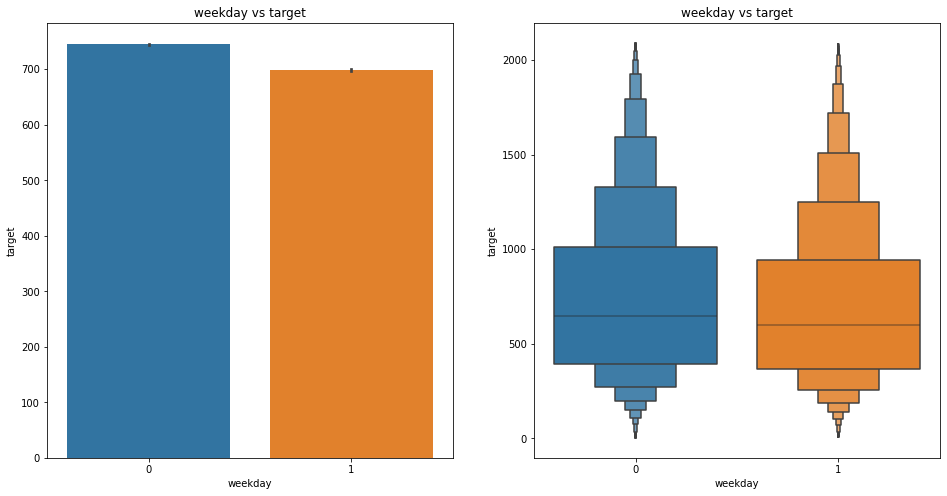

In [32]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('weekday vs target')

sns.boxenplot(data = train, x = 'weekday', y = 'target', ax = ax[1])
ax[1].set_title('weekday vs target')

- 사람들은 평일에 택시를 더 많이 타는 것을 알 수있다.

### 월별로 차이

Text(0.5, 1.0, 'month vs target')

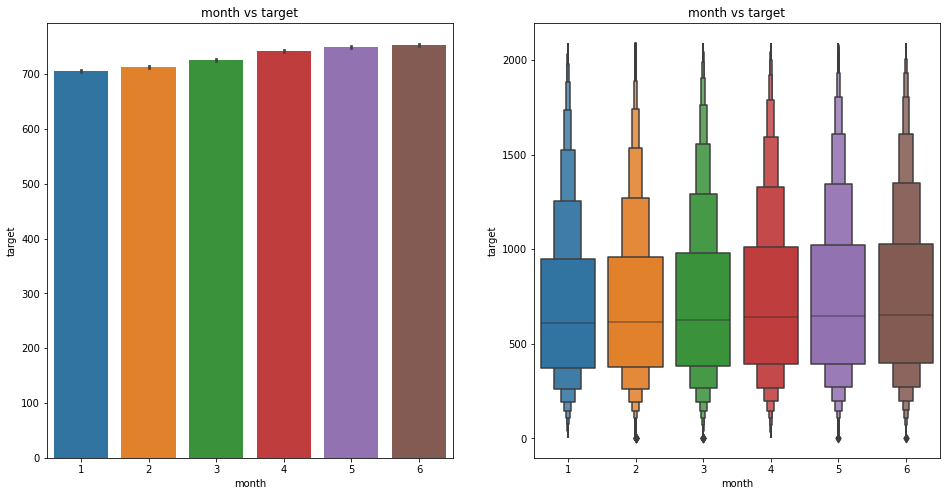

In [33]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('month vs target')

sns.boxenplot(data = train, x = 'month', y = 'target', ax = ax[1])
ax[1].set_title('month vs target')

- 매 달마다 택시를 타는 사람이 늘어나고 있다.

In [34]:
sub_function('month')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


### 일별로 차이

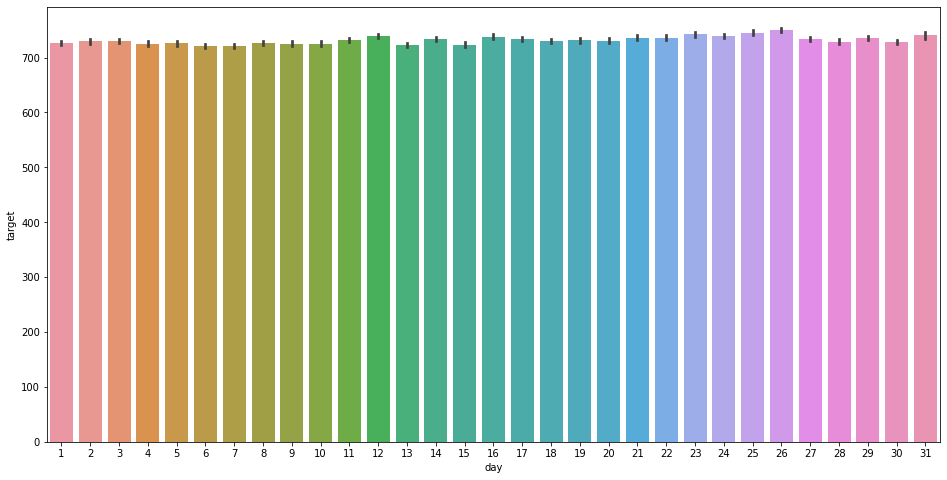

In [35]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target')

- 일별로는 다른 차이점을 발견하지 못했다.

In [36]:
sub_function('day')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


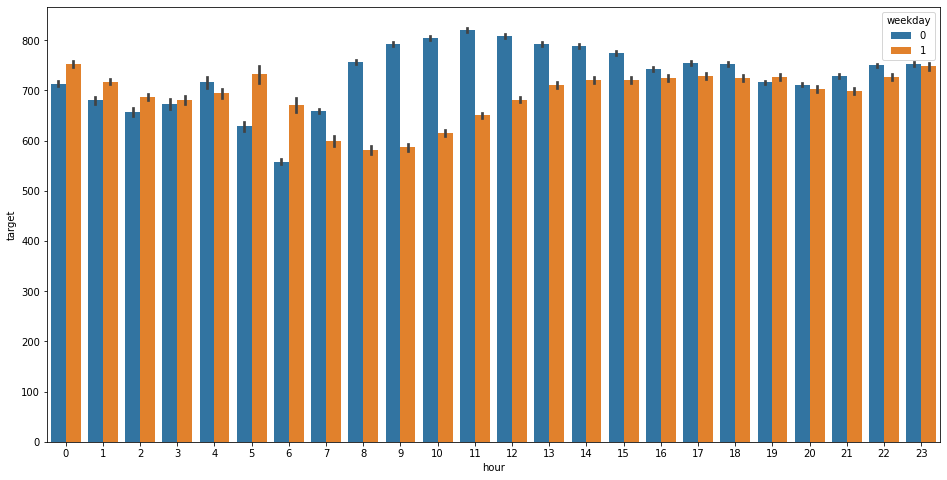

In [37]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')

- 시간별로 공휴일인지 아닌지는 차이가 있는 것 같다.

## 위도 경도를 이용해 거리 구하기

In [38]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'log_target', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [39]:
# haversine 거리 구하는 함수 만들기
def haversine1(lat1, lon1, lat2, lon2, R = 6371.0009):
    
    R = R # 'km'를 나타내기위해 수를 지정해준다.
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1)*cos(lat2)*sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    distance = R * c
    return distance
    

# train과 test에 적용시켜주기
train['distance'] = train.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

test['distance'] = test.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

In [40]:
# haversine을 짯지만 너무 느린관계로 쓰지 않는다.
# from tqdm import tqdm

# def haversine1(df = None):
#     for i in tqdm(df.index):
#         df.loc[i,'distance'] = haversine((df.loc[i,'pickup_longitude'],df.loc[i,'pickup_latitude']),
#                                          (df.loc[i,'dropoff_longitude'],df.loc[i,'dropoff_latitude']), unit = 'm')
#     return df

# distance_train=haversine1(df = train)
# distance_train=pd.DataFrame(distance_train)

# distance_test = haversine1(df = test)
# distance_test = pd.DataFrame(distance_test)

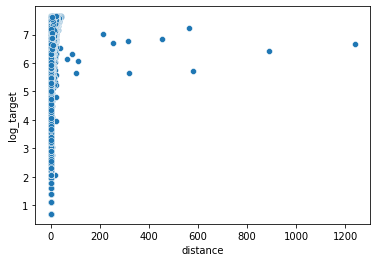

In [41]:
# distance와 target의 분포도를 그려본다.
sns.scatterplot(data =  train, x = 'distance', y = 'log_target')

In [42]:
# 로그를 이용하여 정규화 시켜주기
train['distance'] = train['distance'].apply(lambda x: np.log1p(x))
test['distance'] = test['distance'].apply(lambda x:np.log1p(x))

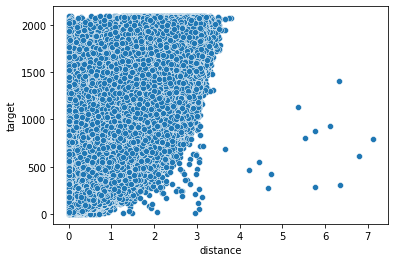

In [43]:
sns.scatterplot(data = train, x = 'distance',y = 'target')

## 평균 속도로 군집화 해주기

In [44]:
train['target_hour'] = train['target'].apply(lambda x:x/3600)
train['velocity'] = train['distance']/train['target_hour']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


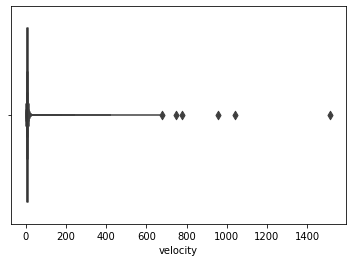

In [45]:
#IQR을 사용하여 데이터를 없애주자.
sns.boxenplot(train['velocity'])

In [46]:
# iqr로 이상치 제거를 해주자.
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx = get_outlier(df=train, column='velocity', weight=1.5)
train.drop(outlier_idx, axis=0, inplace=True)

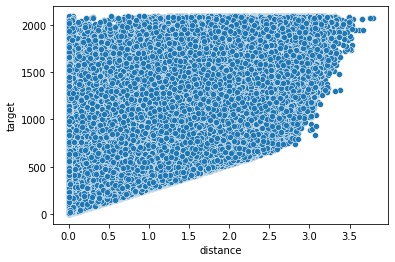

In [47]:
# 거리에 시간을 맞출 생각이기 때문에 distance와 target데이터의 비율을 줘야겟다
sns.scatterplot(data = train, x = 'distance', y = 'target')

In [48]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'log_target', 'month', 'day', 'hour', 'weekday', 'distance',
       'target_hour', 'velocity'],
      dtype='object')

Text(0.5, 1.0, 'dropoff')

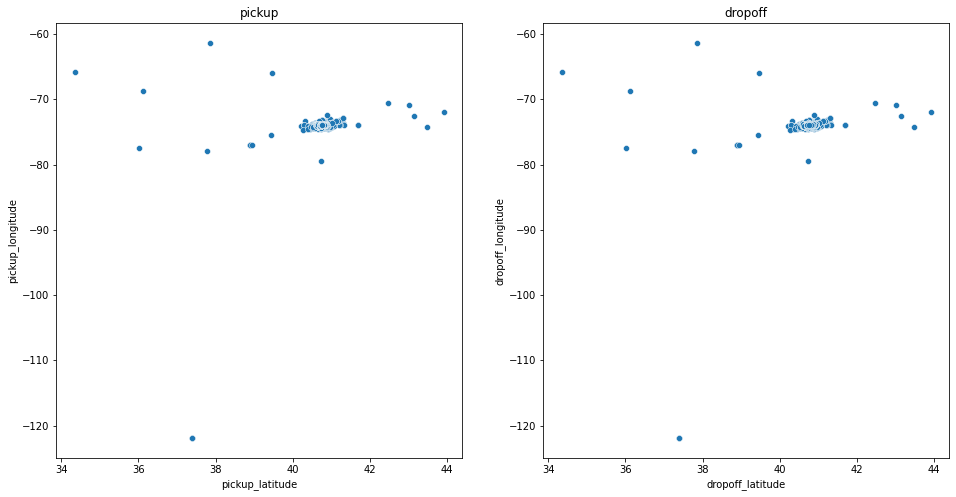

In [49]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.scatterplot(data = train, x = 'pickup_latitude', y = 'pickup_longitude', ax = ax[0])
ax[0].set_title('pickup')

sns.scatterplot(data = train, x = 'dropoff_latitude', y = 'dropoff_longitude', ax = ax[1])
ax[1].set_title('dropoff')

Text(0.5, 1.0, 'dropoff')

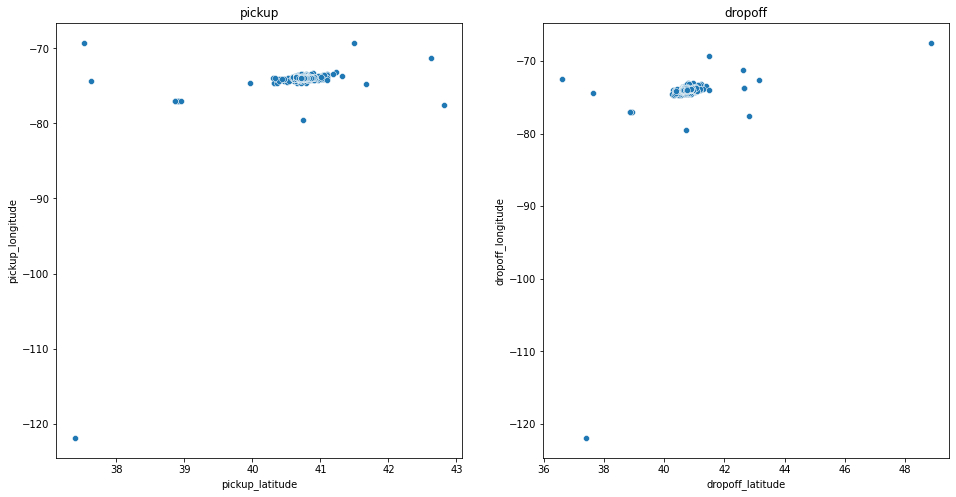

In [50]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.scatterplot(data = test, x = 'pickup_latitude', y = 'pickup_longitude', ax = ax[0])
ax[0].set_title('pickup')

sns.scatterplot(data = test, x = 'dropoff_latitude', y = 'dropoff_longitude', ax = ax[1])
ax[1].set_title('dropoff')

In [51]:
# 눈으로 제거할 수 있는 데이터는 전부 제거해 준 이후에 kmeans를 해주자.
# 40 <=  pickup_latitude  & dropoff_latitude <= 41.5  -> -80 <= pickup_longitude & dropoff_longitude <= -70
delete_index0 = train[(train['pickup_latitude'] < 40) | (train['pickup_latitude'] > 41.5)].index
delete_index1 = train[(train['pickup_longitude'] < -80) | (train['pickup_longitude'] > -70)].index
delete_index2 = train[(train['dropoff_latitude'] < 40) | (train['dropoff_latitude'] > 41.5)].index
delete_index3 = train[(train['dropoff_longitude'] < -80) | (train['pickup_longitude'] > -70)].index

delete_index = [delete_index0,delete_index1,delete_index2,delete_index3]
delete_index
a = []
for i in delete_index:
  for j in i:
    a.append(j)
a = set(a)

for i in a:
    train.drop(i, axis = 0, inplace = True)

In [52]:
# KMeans 불러오기
from sklearn.cluster import MiniBatchKMeans

# k-means clustering 실행
# pickup
kmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 500,random_state= 42).fit(train[['pickup_latitude','pickup_longitude','distance']])
train['pickup_clustering']= kmeans.predict(train[['pickup_latitude','pickup_longitude','distance']])
test['pickup_clustering'] = kmeans.predict(test[['pickup_latitude','pickup_longitude','distance']])

# dropoff
kmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 500).fit(train[['dropoff_latitude','dropoff_longitude','distance']])
train['dropoff_clustering']= kmeans.predict(train[['dropoff_latitude','dropoff_longitude','distance']])
test['dropoff_clustering'] = kmeans.predict(test[['dropoff_latitude','dropoff_longitude','distance']])

In [53]:
# # pickup_clustering과 dropoff_clustering가 어떻게 나누어졌는지 확인한다.
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.scatterplot(data = train, x = 'pickup_latitude', y = 'pickup_longitude', hue = 'pickup_clustering', ax = ax[0])
# ax[0].set_title('pickup_clustering graph')

# sns.scatterplot(data = train, x = 'dropoff_latitude', y = 'dropoff_longitude', hue = 'dropoff_clustering', ax = ax[1])
# ax[1].set_title('dropoff_clustering graph')

## store_and_fwd_flag

In [54]:
train['store_and_fwd_flag'].value_counts()

N    1318671
Y       6803
Name: store_and_fwd_flag, dtype: int64

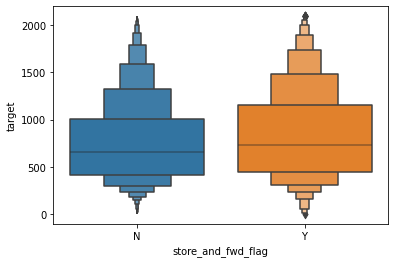

In [55]:
sns.boxenplot(data = train, x = 'store_and_fwd_flag', y = 'target')

- Y가 N보다 더 높은 시간은 나타낸다.

In [56]:
sub_function('store_and_fwd_flag')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


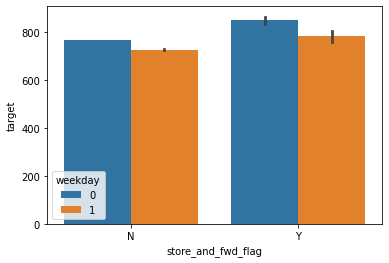

In [57]:
sns.barplot(data = train, x = 'store_and_fwd_flag', y = 'target', hue = 'weekday')

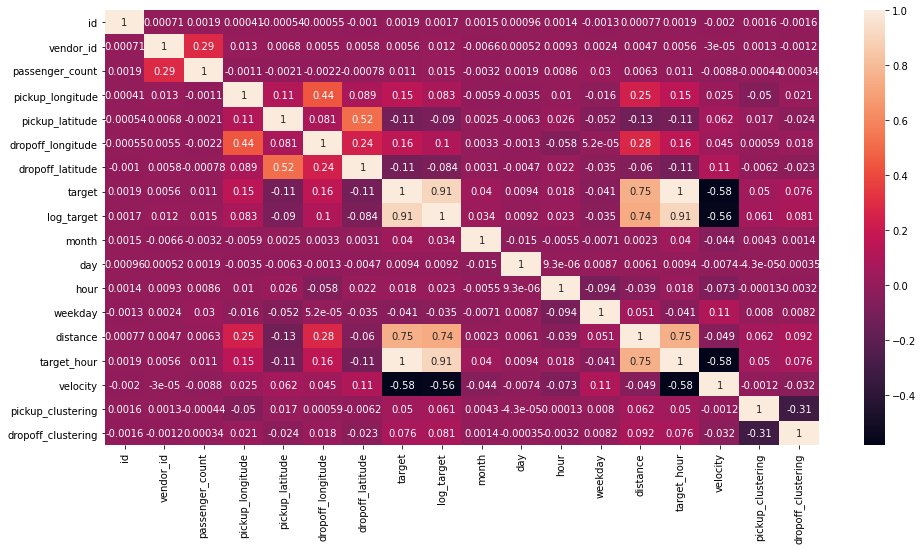

In [58]:
plt.figure(figsize = (16,8))
train_corr=train.corr()
sns.heatmap(train_corr, annot = True)

In [59]:
print('-------- train ----------')
print(train['distance'].describe())
print('------------ test -----------')
print(test['distance'].describe())

-------- train ----------
count    1.325474e+06
mean     1.203921e+00
std      5.546969e-01
min      0.000000e+00
25%      8.028593e-01
50%      1.114359e+00
75%      1.521158e+00
max      3.792010e+00
Name: distance, dtype: float64
------------ test -----------
count    625134.000000
mean          1.254025
std           0.625966
min           0.000000
25%           0.802866
50%           1.129380
75%           1.585670
max           6.944129
Name: distance, dtype: float64


In [60]:
# 그래서 거리의 사분위수를 이용해 나눠주기로 하자.
# train['distance'].describe()

# train.loc[train['distance'] <= 0.8029981 , 'distance_binning'] = 0
# train.loc[(train['distance'] >=0.8029981) & (train['distance'] < 1.129586), 'distance_binning'] = 1
# train.loc[(train['distance'] >= 1.129586) & (train['distance'] < 1.584439 ), 'distance_binning'] = 2
# train.loc[train['distance'] >= 1.584439, 'distance_binning'] = 3

# test.loc[test['distance'] <= 0.803040 , 'distance_binning'] = 0
# test.loc[(test['distance'] >= 0.803040) & (test['distance'] < 1.129592), 'distance_binning'] = 1
# test.loc[(test['distance'] >= 1.129592) & (test['distance'] < 1.585919 ), 'distance_binning'] = 2
# test.loc[test['distance'] >= 1.585919, 'distance_binning'] = 3

In [61]:
# sns.barplot(data = train, x = 'distance_binning', y = 'target')

- 변수마다 연관이 있는 걸로 보여진다.

In [62]:
delete_index=train[(train['passenger_count'] == 7)|(train['passenger_count'] == 8)].index
train=train.drop(delete_index,axis = 0)

sub_function('passenger_count')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


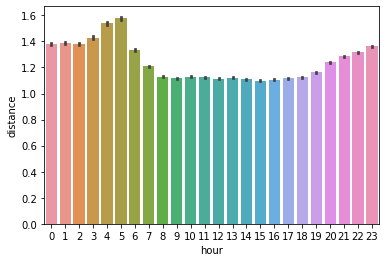

In [63]:
# 3~5시 사이에 높은 이동량을 보인다.
sns.barplot(data = train, x = 'hour', y = 'distance')

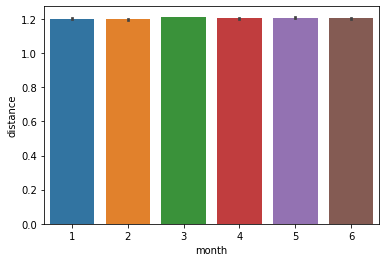

In [64]:
# 눈이 올 때 1월과 2월에 거리가 더 적다.
sns.barplot(data = train, x = 'month', y = 'distance')

### 가정 1 : 날씨가 추운 1~2월은 적은 거리도 추운 날씨 때문에 택시를 탈 것이다.

![%EC%BA%A1%EC%B2%98.PNG](attachment:%EC%BA%A1%EC%B2%98.PNG)

- 변수 0 :1~2월은 겨울인 달
- 변수 1 :3~6월은 겨울이 아닌 달

In [65]:
# 겨울인 1~2월에는 사람들이 적은 거리도 택시를 탈 것이다.
train['cold'] = 1
train.loc[(train['month'] == 1) | (train['month'] == 2), 'cold'] = 0

test['cold'] = 1
test.loc[(test['month'] == 1) | (test['month'] == 2), 'cold'] = 0

In [66]:
train.cold.value_counts()

1    895901
0    429570
Name: cold, dtype: int64

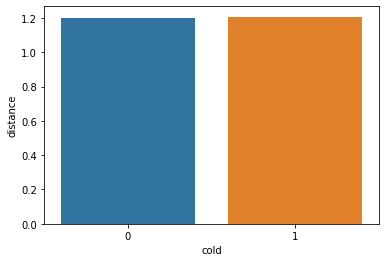

In [67]:
sns.barplot(data = train, x = 'cold', y = 'distance')

## 모델링

In [68]:
!pip install catboost

     |████████████████████████████████| 67.3MB 75kB/s 


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [70]:
dummies=['vendor_id','store_and_fwd_flag','weekday','cold','pickup_clustering','dropoff_clustering','month','hour']
# train 데이터 더미화
train_data = pd.get_dummies(data = train[dummies], columns = dummies)
train_data = pd.concat([train_data,train['distance']],axis = 1)

# test 데이터 더미화
test_dummies=pd.get_dummies(test[dummies], columns = dummies)
test_data = test_dummies
test_data = pd.concat([test_data,test['distance']],axis = 1)

In [71]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


- rmsle를 사용하여 좋은 모델을 골라주고 파라미터를 수정한다.

In [106]:
def rmsle(actual_values, predicted_values, convertExp=True):
    """
    - root mean squared log error는 error를 로그화값으로 변환하고, 제곱하고, 평균을 내고, 루트를 씌웁니다.
    - skewness를 해결하기 위해 np.log1p를 했기 때문에, 값을 예측할 때 이를 다시 변환해서 처리해주는 것이 필요합니다. 
    """
    if convertExp==True:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    log_predicted_values = np.log(np.array(predicted_values)+1)
    log_actual_values = np.log(np.array(actual_values)+1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = np.square(log_predicted_values - log_actual_values)
    return np.sqrt(difference.mean())

In [ ]:
# xgbregressor를 수행해준다.
from sklearn.metrics import make_scorer, mean_squared_error
params = {
        # 'min_child_weight': [1,3,5,7,9,11],
        'gamma': [0.1,0.001,1,2,3], 
        # 'subsample': [0.6,0.8,1],
        # 'colsample_bytree': [1.0,1.2,1.4],
        # 'max_depth': [12,14,16,18]
        }
cv = KFold(n_splits= 5, shuffle = True, random_state = 42)
xgb = XGBRegressor(learning_rate= 0.02,random_state = 42, tree_method = 'gpu_hist')
xgb_gcv = GridSearchCV(estimator = xgb, param_grid = params, cv = cv, scoring= make_scorer(rmsle, greater_is_better = False) )
xgb_gcv.fit(train_data,train['log_target'])
model = xgb_gcv.best_estimator_
xgb_pred = model.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
xgb_pred = pd.DataFrame(xgb_pred, columns = ['xgb_pred'])
xgb_pred = xgb_pred['xgb_pred'].apply(lambda x: np.exp(x) - 1)

# # xgboost 가 0.472로 가장 높게 나왔다.

[16:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [102]:
# # catboostregressor를 수행해준다.

# cat = CatBoostRegressor()
# cat.fit(train_data, train['log_target'])
# cat_pred = cat.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
# cat_pred = pd.DataFrame(cat_pred, columns = ['cat_pred'])
# cat_pred = cat_pred['cat_pred'].apply(lambda x: np.exp(x) - 1)

In [ ]:
y_pred = xgb_pred
submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)
print(submission)

               id  trip_duration
0       id3004672     347.337828
1       id3505355     349.014481
2       id1217141     220.416995
3       id2150126     473.054416
4       id1598245     181.824227
...           ...            ...
625129  id3008929     181.824227
625130  id3700764     499.643476
625131  id2568735     547.404697
625132  id1384355     616.064752
625133  id0621643     496.851043

[625134 rows x 2 columns]


In [75]:
# submission

In [112]:
# LGBMRegressor를 수행해준다.
param_grid = {
    # 'boosting_type': ['dart'],
    # 'metric': ['rmsle'],
    # 'max_depth': [4,5,6,7,8,9], 
    'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.01,0.001],
    # 'early_stopping_round': [10,20,30,40,50],
    # 'n_estimators':[50,100,150,200],
    }

cv = KFold(n_splits= 5, shuffle= True)
lgb_gcv = GridSearchCV(estimator = LGBMRegressor(), param_grid= param_grid, cv = cv, n_jobs= -1)
lgb_gcv.fit(train_data, train['log_target'])
print(lgb_gcv.best_params_)

model = lgb_gcv.best_estimator_
model.fit(train_data, train['log_target'])
y_pred  = model.predict(test_data)

print(lgb_gcv.best_params_)
# 예측값을 로그 씌우기 전으로 바꿔준다.
lgb_pred = pd.DataFrame(lgb_pred, columns = ['lgb_pred'])
lgb_pred = lgb_pred['lgb_pred'].apply(lambda x: np.exp(x) - 1)

KeyboardInterrupt: ignored

In [ ]:
lgb_gcv.estimator

In [ ]:
# submission

In [ ]:
# # RandomForestRegressor를 수행해준다.
# rfg = RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25)
# rfg.fit(train_data, train['log_target'])
# y_pred = rfg.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
# y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # submission에 저장하여 제출한다.
# submission['trip_duration'] = y_pred
# submission.to_csv("submission.csv", index_label=False, index = False)

In [ ]:
# importances = {}
# for name, value in zip(train_data.columns, xgb.feature_importances_):
#   importances[name] = value

In [ ]:
# plt.figure(figsize = (20,12))
# plt.barh(train_data.columns,xgb.feature_importances_)

In [ ]:
# # 모델들을 dict를 사용하여 모아준다.
# models = {'lr': LinearRegression(), 'Ridge':Ridge(), 'Lasso':Lasso(), 'lgb': LGBMRegressor(), 'cat':CatBoostRegressor()}

# # train과 test로 쌓을 데이터를
# train_final_value = pd.DataFrame([])
# test_final_value = pd.DataFrame([])
# X_train, X_test, y_train, y_test = train_test_split(train_data, train['log_target'], test_size = 0.2, random_state = 42)

# # 데이터 예측값들 쌓아보기
# for model_name, model in models.items():
#   print(model_name, model)
#   model = model.fit(X_train, y_train)
#   train_pred = model.predict(X_test)
#   test_pred = model.predict(test_data)

#   train_final_value[model_name] = train_pred
#   test_final_value[model_name] = test_pred

# # 단일 모델로 돌렸을 때 xgbregressor가 가장 높게 나왔으므로 meta_model로 사용한다.
# xgb = XGBRegressor()
# xgb.fit(train_final_value, y_test)
# y_pred = xgb.predict(test_final_value)

# y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# submission['trip_duration'] = y_pred
# submission.to_csv("submission.csv", index_label=False, index = False)
# print(submission)

In [ ]:
# !pip install pycaret[full]

In [ ]:
# pycaret 라이브러리를 불러오기
# from pycaret.regression import *

In [ ]:
# pycaret에 넣기위해서 log_target을 dataframe에 넣어준다.
# train_data = pd.concat([train_data, train['log_target']], axis = 1)

In [ ]:
# from sklearn.impute import SimpleImputer

In [ ]:
# pycaret을 수행하기 위한 연속형 변수 지정
# numerical_list = ['distance']

# setup 지정
# 에러가 일어나서 패스
# pycaret_setup = setup(data = train_data, target = 'log_target', fold = 5, session_id = 42,imputation_type='iterative')